In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
from scipy.io import loadmat, savemat
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

  Cloning https://github.com/ieeg-portal/ieegpy.git to /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-l38hidy_
  Running command git clone -q https://github.com/ieeg-portal/ieegpy.git /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-l38hidy_
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb


In [37]:
#concatenates each sequence to form a GDF -- removes the sequences in each runtime
def concat_seqs(I,seqs):
    if seqs[I,0].size != 0:
        X = np.concatenate(np.concatenate(seqs[I,0]))
    else:
        X = []
    return X #recreates the GDF from which the sequence was parsed - I can be used to iterate through the whole code

#take the GDF/runtime --> find the max per ch 
#I refers to the index of the specific sequence runtime we want.
def max_per_runtime(seqs,values,I):
    seq_concat = concat_seqs(I,seqs);
    if len(seq_concat) != 0: #skip past the "no spike detected" sequence runtimes
        ch_uniq = np.unique(seq_concat[:,0])
        all_maxvals = []
        for ch in ch_uniq:
            x = np.where(seq_concat[:,0] == ch)[0] #should give you an array with positions where that unique ch was used.
            all_maxes_per_ch = []
            for x in x: #calls on each array in x --> (example. i == [10 34, 70] for when spike channel == 7)
                val = values[I,0][x] - np.mean(values[I,0][x])
                max_val = np.max(np.abs(val)) #FEATURE APPLICATIONS
                all_maxes_per_ch.append(max_val)
            all_maxvals.append([ch, all_maxes_per_ch]) 
    else: #the ones with spikes now
        all_maxvals = []
    return all_maxvals #will return all max values in a runtime

#take the singular max calculator from above and make it run for all sequence run_times
def maxes_for_all(seqs,values):
    all_max_vals = []
    for I in range(len(values)):
        runtime_max_vals = max_per_runtime(seqs,values,I)
        all_max_vals.append(runtime_max_vals)
    return all_max_vals

def create_single_matrix(all_max_vals):
    new_mat = []
    for i in range(len(all_max_vals)):
       for k in range(len(all_max_vals[i])):
           a = all_max_vals[i][k]
           new_mat.append(a)
    return new_mat

def create_uniqch(all_max_vals,chLabels):
    new_mat = create_single_matrix(all_max_vals)
    ch_id = range(len(chLabels[0][0]))
    ch_id = (x+1 for x in ch_id)
    total_maxes = []
    total_maxes_fin = []
    for ch in ch_id:
        ch_maxes = []
        for i in range(len(new_mat)):
            if new_mat[i][0] == ch:
                x = new_mat[i][1]
                ch_maxes.append(x)
        total_maxes.append(ch_maxes)
        
    for chX in total_maxes:
        if len(chX) != 0:
            x = np.concatenate(chX)
            total_maxes_fin.append(x)
        else:
            total_maxes_fin.append([])
        
    return total_maxes_fin

def filter_ch(total_maxes):
    #create a cumulative list that tracks the amount of spikes in each channel
    cumul_list = []
    for maxes in total_maxes:
        cumul_list.append(len(maxes))
    #create a histogram, use the edge of first bin as the cutoff
    _,bins,_ = plt.hist(cumul_list,bins=2*146)
    plt.close()
    filt_maxes = []
    for ch in total_maxes:
        if len(ch) <= bins[1]: #uses the cutoff to threshold what we consider artifacts in a channel
            filt_maxes.append([]);
        else:
            filt_maxes.append(ch)
    return filt_maxes #new total_maxes matrix with no deemed low activity channels

#patient SOZ channels loaded via whichPts-1 indexing and then changed to match ChLabels structure
def prep_chlabels(WhichPts,SOZ_chlabels):
    hup203_soz = (SOZ_chlabels.iloc[WhichPts])
    hup203_soz = [x for x in hup203_soz]
    hup203_soz = hup203_soz[0].replace(" ","")
    hup203_soz = hup203_soz.split(',')
    hup203_soz = [x+'-CAR' for x in hup203_soz]
    return hup203_soz

def box_plot(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def box_plot_outliers(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

#full pipeline in 1 function
def load_split(filename):
    pathway = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Results_v1/split_'
    filetype = '.mat'
    
    split_X = loadmat(pathway+filename+filetype);
    split = split_X
    chLabels = np.transpose(split['chLabels'])
    values = np.transpose(split['values'])
    seqs = np.transpose(split['sequences'])
    leaders = np.transpose(split['leaders'])
    global_coi = np.transpose(split['global_coi'])
    return split, chLabels, values, seqs #global_coi, leaders #you can comment in the global_coi and leaders if need be.

def calc_maxes_and_stats(filename, WhichPts):
    
    split, chLabels, values, seqs = load_split(filename);
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts,SOZ_chlabels)
    SOZ_find = []
    for i in range(len(hup_soz)):
        find = np.where(hup_soz[i] == chLabels[0][0])[0]
        SOZ_find.append(find)

    SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

    SOZ_find2 = [x+1 for x in SOZ_find]
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])

    nonSOZ_all = np.concatenate(nonSOZ_maxes)
    SOZ_all = np.concatenate(SOZ_maxes)
    
    stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)

    return pval, SOZ_all, nonSOZ_all

def maxes_for_plot(filename, WhichPts):
    split, chLabels, values, seqs = load_split(filename)
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts,SOZ_chlabels)
    SOZ_find = []
    for i in range(len(hup_soz)):
        find = np.where(hup_soz[i] == chLabels[0][0])[0]
        SOZ_find.append(find)

    SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

    SOZ_find2 = [x+1 for x in SOZ_find]
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])

    nonSOZ_all = np.concatenate(nonSOZ_maxes)
    SOZ_all = np.concatenate(SOZ_maxes)
    
    stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)
    return filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval, chLabels

def plot_scatter(filename, WhichPts):
    
    filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval,chLabels = maxes_for_plot(filename, WhichPts)
    
    #label_idx = np.arange(1,147)
    label_idx = range(len(chLabels[0][0]))
    label_idx = [x+1 for x in label_idx]
    plt.figure(figsize=(20,10))
    for x, y in zip(label_idx,filt_maxes):
        plt.scatter([x]*len(y), y, color='b',marker=".", s=1)

    for xe, ye in zip(SOZ_find2, SOZ_maxes):
        plt.scatter([xe] * len(ye), ye,color='r',marker=".", s=1)

    plt.title('Max values for each Channel in '+filename)
    SOZ_label = mpatches.Patch(color='r', label='SOZ') #imported matplotlib.patches -> manually creates legend since auto-detection of the legend via plt.legend() didn't work
    nonSOZ_label = mpatches.Patch(color='b', label='non-SOZ')
    plt.legend(handles=[SOZ_label,nonSOZ_label])
    plt.ylabel('Amplitude')
    plt.xlabel('Channel')
    plt.show()
    return 
    
def plot_box_per_pt(filename, WhichPts):
    _, _, _, _, nonSOZ_all, SOZ_all, _, _ = maxes_for_plot(filename, WhichPts)

    plt.figure(figsize=(10,7))
    bp1 = box_plot(nonSOZ_all, [1], 'blue', 'lightblue')
    bp2 = box_plot(SOZ_all, [2], 'red', 'pink')
    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
    plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
    plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for '+filename)
    plt.ylabel('Amplitude')

    x1 = 1
    x2 = 2
    y1 = 1500
    y2 = 1600
    y3 = 1900
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    stat_string = 'statistically significant, p='
    pval_string = stat_string+str(pval)
    plt.text(3/2,1620, s=pval_string, ha='center', va='bottom', color='k')
    plt.ylim([0,1700])
    plt.xlabel('Channel Label')
    plt.show()

    return

In [32]:
#retrieve filename & whichPts
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/filename.pkl", "rb") as f:   #Unpickling
    filename = pickle.load(f)
    
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/whichPts.pkl", "rb") as Q:   # Unpickling
    whichPts = pickle.load(Q)

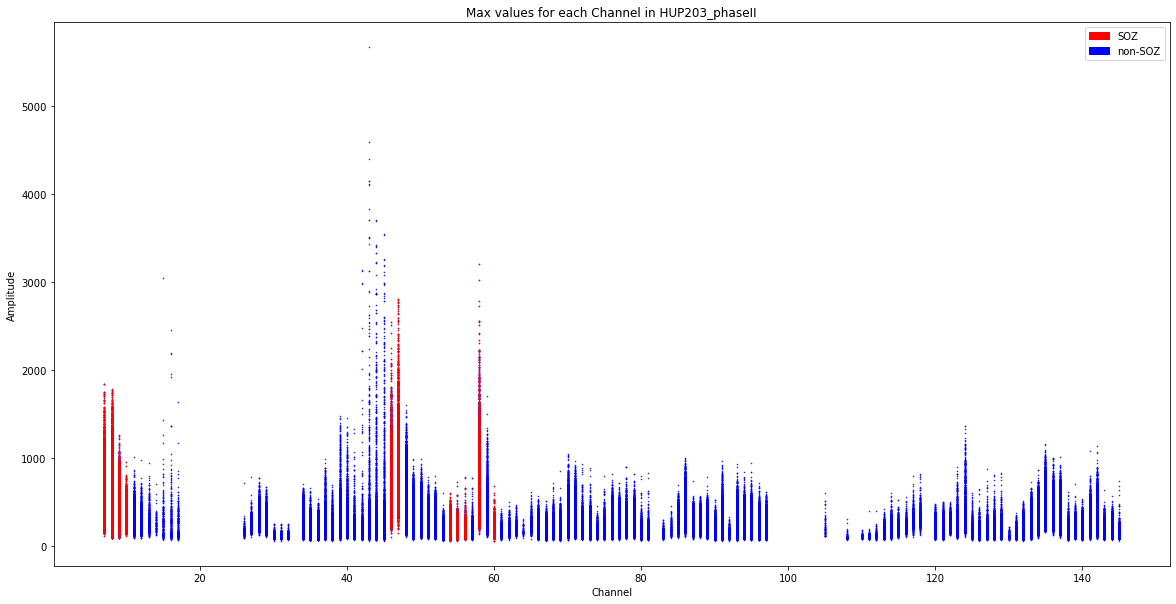

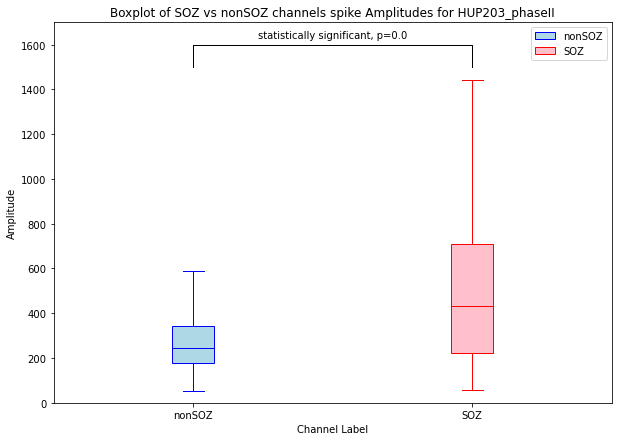

63.03794300000004


In [38]:
#EXAMPLE of CODE - on patient 98 - HUP203_phaseII

#takes about 136 seconds (2.5mins) per patient
import time
start = time.process_time()

#my code
#pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats('HUP203_phaseII',98)
plot_scatter('HUP203_phaseII',98)
plot_box_per_pt('HUP203_phaseII',98)
#mycode

print(time.process_time() - start)

0.0 (45054,) (342192,)
